In [2]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, 
                             auc, RocCurveDisplay)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

def load_data(filepath):
    """
    Loads the dataset from a CSV file and preprocesses it.

    Parameters:
    - filepath: Path to the CSV file.

    Returns:
    - DataFrame after preprocessing.
    """
    df = pd.read_csv(filepath)
    df['Re_kpc'] = df['Re'] * df['scale']
    df = df.drop(df[df.Surf_density_grad > 0].index)
    
    #Separating sSFR gradients into the different categories
    q_vals = df['sSFR_grad'].quantile([0.34, 0.665]).tolist()
    df.loc[(df['sSFR_grad'] < q_vals[0]), 'sSFR_gradient'] = int(0)
    df.loc[(df['sSFR_grad'] > q_vals[0]) & (df['sSFR_grad'] < q_vals[1]), 'sSFR_gradient'] = int(1)
    df.loc[(df['sSFR_grad'] > q_vals[1]), 'sSFR_gradient'] = int(2)

    return df

def random_forest(data, target_column, test_size=0.2, random_state=50):
    """
    Trains a Random Forest classifier on the provided data and evaluates it.

    Parameters:
    ----------
    - data: DataFrame containing the feature data and target variable.
    - target_column: The name of the target variable column, in this case one of the four galaxy gradients.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.

    Returns:
    - None
    """
    df = data.dropna()  
    X = df.drop(columns=[target_column]) 
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

    # Hyperparameter tuning with GridSearchCV
    RF_parameters = {
        'max_depth': [5, 13, 21],
        'min_samples_leaf': [2, 5, 8],
        'min_samples_split': [5, 6, 7],
        'n_estimators': [100, 170, 140]
    }

    grid_search = GridSearchCV(
        RandomForestClassifier(),
        param_grid=RF_parameters,
        scoring='accuracy',
        n_jobs=5,
        cv=5,
        verbose=True
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_ 
    
    # Save the model
    joblib.dump(model, 'random_forest_best_estimator.joblib')

    # Predict and evaluate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("The accuracy of the model is: ", accuracy)

    # Feature importance
    plot_feature_importance(model, X_train)

    # Permutation Importance
    compute_permutation_importance(model, X_test, y_test, X_train)


    # Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test)

    # ROC Curve
    plot_roc_curve(model, X_train, y_train, X_test, y_test, n_classes=3)


def plot_feature_importance(model, X_train):
    """
    Plots and saves feature importance of the model.
    """
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    

    fig, ax = plt.subplots(figsize=(9, 4))  

    sns.barplot(x=feature_importances, y=feature_importances.index, hue=feature_importances.index,
                palette='crest', ax=ax, legend=False)

   
    ax.set_xlabel('Feature Importance Score', fontsize=15)
    ax.set_ylabel('Features', fontsize=15)
    ax.set_title("Important Features", fontsize=15)
    ax.tick_params(labelsize=15)

    
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    plt.show()
    plt.close()

def compute_permutation_importance(model, X_test, y_test, X_train):
    """
    Computes and displays the permutation importance of the features.

    Parameters:
    - model: Trained Random Forest model.
    - X_test: Testing feature set.
    - y_test: Testing target values.
    - X_train: Training feature set (for feature names).
    """
    # Compute permutation importance
    r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)

    print("\nPermutation Importance:")
    for i in r.importances_mean.argsort()[::-1]:
        gal_prop = f"{X_train.columns[i]:<15} "
        permutation_val = f"{r.importances_mean[i]:.3f}"
        print(gal_prop, permutation_val)

def plot_confusion_matrix(model, X_test, y_test):
    """
    Plots and saves the confusion matrix of the model predictions.
    """
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    fig, ax = plt.subplots(figsize=(8, 6)) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="RdPu", ax=ax)  
    
    ax.set_title('Confusion Matrix', fontsize=15)
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    ax.tick_params(labelsize=10)
    
    plt.tight_layout() 
    plt.show()

    plt.close()

def plot_roc_curve(model, X_train, y_train, X_test, y_test, n_classes):
    """
    Plots the ROC curve for the model.

    Parameters:
    ----------
    - model: Trained Random Forest model.
    - X_train: Training feature set.
    - y_train: Training target values.
    - X_test: Testing feature set.
    - y_test: Testing target values.
    - n_classes: Number of unique classes.
    """
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    y_score = model.predict_proba(X_test)

    fpr, tpr, roc_auc = dict(), dict(), dict()
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC Curve
    fig1, ax = plt.subplots(figsize=(7, 7))
    colors = cycle(["#0D47A1", "#E65100", "#4CAF50"])

    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for class {class_id}",
            color=color,
            ax=ax,
        )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC Curve "
    )
    plt.xlim(-0.01, 1)
    plt.ylim(-0.01, 1.015)
    plt.show()
    plt.close()


The accuracy of the model is:  0.6536


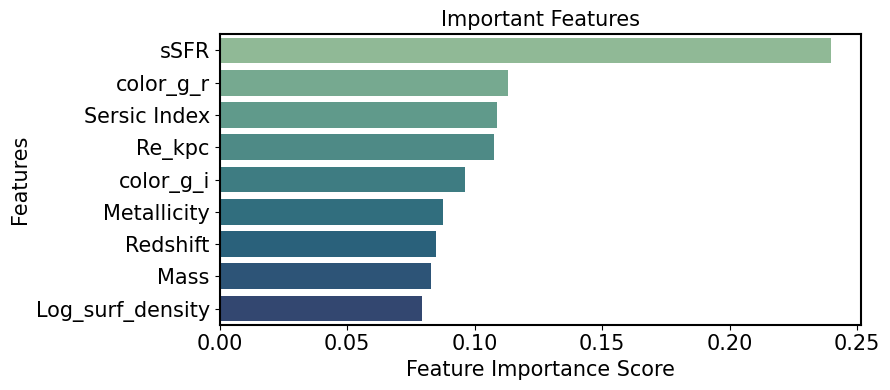


Permutation Importance:
sSFR             0.213
Sersic Index     0.066
color_g_r        0.066
color_g_i        0.035
Re_kpc           0.032
Mass             0.019
Metallicity      0.019
Redshift         0.012
Log_surf_density  0.008


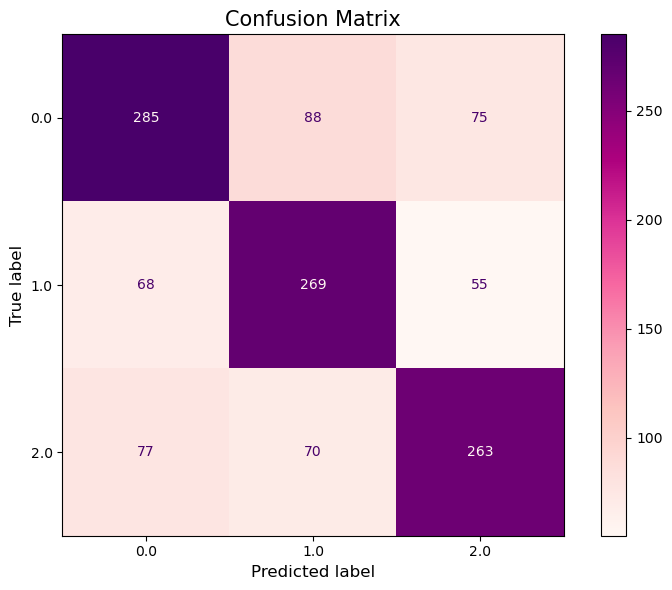

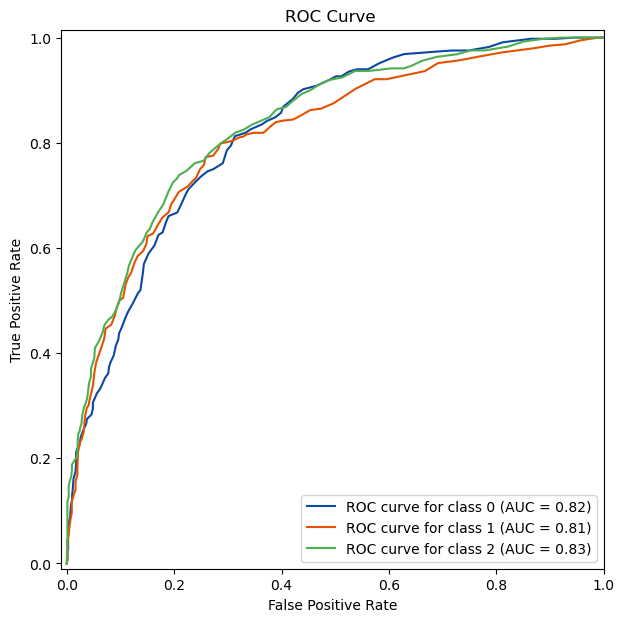

In [3]:
data_file = 'Gradient_data.csv'

data_use = load_data(data_file)

random_forest(data_use, 'sSFR_gradient')